# Image Search on Brain MRI Scans

This example demonstrates how to store [brain scan images](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) as vector embeddings in KDB.AI, then how to search this dataset to instantly retrieve similar images.

Brain tumors are intricate due to variations in size and location, therefore understanding their nature is challenging. Professional neurosurgeons are essential for accurate MRI analysis, but in developing nations, the scarcity of skilled doctors and tumor knowledge results in time-consuming report generation from MRI scans. 

A potential solution lies in automated systems like vector database search, which could help alleviate this issue. Using semantic search, KDB.AI enables users to effectively retrieve the most similar scan images quickly even when the query and database content aren't an exact match, leveraging semantic context. 

### Aim 
In this tutorial, we'll walk through the process of storing images in a vector database, using a pre-trained neural network to generate data structures known as vector embeddings. We will use KDB.AI's vector database offering to find images with similar vector embeddings to an input query image. We will cover the following topics:

1. Load Image Data
1. Create Image Vector Embeddings
1. Store Embeddings in KDB.AI
1. Query the KDB.AI Table
1. Search For Similar Images To A Target Image
1. Delete the KDB.AI Table

---

## 0. Setup

### Import Packages

In [1]:
# download data
import os
from zipfile import ZipFile

In [2]:
# embeddings
from tensorflow.keras.utils import image_dataset_from_directory
from huggingface_hub import from_pretrained_keras
from PIL import Image
import numpy as np
import pandas as pd

<div class="alert alert-block alert-warning">
<b>Getting a warning?</b><br/>
We can ignore the 'Could not find TensorRT' warning as it will not affect the code later on in the notebook.
</div>

In [3]:
# timing
from tqdm.auto import tqdm

In [4]:
# vector DB
import kdbai_client as kdbai
from getpass import getpass
import time

In [5]:
# plotting
import hdbscan
import umap.umap_ as umap
from matplotlib import pyplot as plt

### Define Helper Functions

In [6]:
def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()

In [7]:
def plot_image(axis, source: str, label=None) -> None:
    axis.imshow(plt.imread(source))
    axis.axis("off")
    title = (f"{label}: " if label else "") + source.split("/")[-1]
    axis.set_title(title)

## 1. Load Image Data

### Dataset Overview

The dataset that will be used in this sample is the [Brain Tumor Classification images taken from Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri).
The dataset consists of MRI brain scan images organized into four classes based on the presence of a tumor in the image: glioma, melignioma, pituitary, and no tumor.

The original Kaggle dataset contains two folders a `Training` folder and a `Testing` folder, both of which contain images organized by these tumor class.
As a pre-processing step, we have resized the original images to be of dimensions (224, 224, 3) with the height & width being 224 and there being 3 dimensions for the Red, Green, and Blue pixel intensity.
We have also renamed each image corresponding to its class and given each one a unique ID within its directory.

Post processing, the `Training` folder in this original dataset was used to train the ResNet model which we use to create the embeddings in this notebook.
The post processed `Testing` folder has been renamed to `data` and will be what we use in this notebook.
This data has not been seen by our ResNet model and will help to avoid any overfitting when it comes to creating the vector embeddings.

### Define List Of Paths To The Extracted Image Files

Next, let's extract image file paths from different subfolders within the 'Testing' directory. These are needed to pass to our function in the next section to create embeddings.

In [8]:
def extact_file_paths_from_folder(parent_dir: str) -> dict:
    image_paths = {}
    for sub_folder in os.listdir(parent_dir):
        sub_dir = os.path.join(parent_dir, sub_folder)
        image_paths[sub_folder] = [
            os.path.join(sub_dir, file) for file in os.listdir(sub_dir)
        ]
    return image_paths

In [9]:
image_paths_map = extact_file_paths_from_folder("data")

Lets take a look at some example images from each category. The images are numbered, so we can choose a number between 1-100 and fetch that image from each folder:

### Visualize Some Of The Images

We can then plot each of our demo images using the `plot_image()` helper function:

In [10]:
image_index = 20  # feel free to change this!

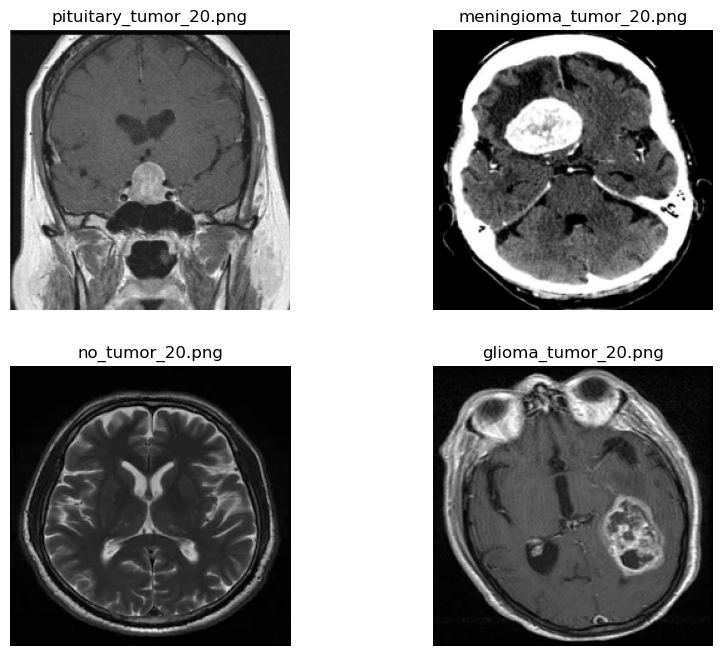

In [11]:
# create subplots
_, ax = plt.subplots(nrows=len(image_paths_map) // 2, ncols=2, figsize=(10, 8))
axes = ax.reshape(-1)

# get image at specified index
for i, (_, image_paths) in enumerate(image_paths_map.items()):
    for path in image_paths:
        if path.endswith(f"{image_index}.png"):
            break

    # plot each image in subplots
    plot_image(axes[i], path)

### Load data using `image_dataset_from_directory()`

The `image_dataset_from_directory()` function saves each image with a class label corresponding to the image's directory. This is a quick and easy way to get our data and its labels in the right format for embedding.

In [12]:
dataset = image_dataset_from_directory(
    "data",
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    seed=1,
    image_size=(224, 224),
    batch_size=1,
)

Found 394 files belonging to 4 classes.


## 2. Create Image Vector Embeddings

To create our image embeddings, we will use a neural network that has been pre-trained on the brain tumor classification problem. In this example, we will use a network containing a ResNet-50 backbone. ResNet-50 is a popular neural network architecture for general image classification tasks.

ResNet-50 was originally trained on the ImageNet dataset - although this dataset contains millions of images, including of MRI scans, it does not contain examples of different brain tumor images. Therefore, our custom model was created by taking ResNet-50, pre-trained on ImageNet, and re-training it to classify MRI brain scan images.

This is an example of Transfer Learning - we are taking a model that has been pre-trained for a task (ResNet-50 for ImageNet classification) and using it as a starting point to solve a more specific problem (classify MRI brain scan images).s.

### Load Pre-Trained Classification Neural Network

In [13]:
model = from_pretrained_keras("KxSystems/mri_resnet_model")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 16392     
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 23604140 (90.04 MB)
Trainable params: 23551020 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


We can see that the model has four layers: ResNet-50, Flatten, and two Dense layers. The ResNet-50 "layer" is really many layers, abstracted under one name. This is why it contains millions of parameters. The Flatten layer does not contain any parameters - its sole purpose is to "flatten" the outputs of ResNet-50 into a 2048-dimensional vector, known as a feature vector. The final two Dense layers transform the ResNet-50 feature vector into a 4-dimensional classification of the input image. 

### Transform Classification Network Into Embedding Network

For a better understanding of the `model.summary()`, here is a diagram representation of the network:

![mri-network-diagram](images/mri_network_diagram.png)

Although the Dense layers were essential for training ResNet-50 to classify our four brain tumor classes, we will no longer be needing them. In this example, we are interested in the embedding, not the classification output. Therefore, we will remove the last two layers of the pre-trained model by calling `pop()`. This means that the new output of the model is the 2048-dimensional feature vector - the ResNet-50 embedding of the input image.

In [15]:
model.pop()
model.pop()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


### Use Embedding Network To Create Image Embeddings

##### Generate Embeddings

To generate the image embeddings, we will iterate through the dataset, get the 2048-dimension embedding by calling `model.predict()` on the image, and save the corresponding class vector.

In [16]:
# create empty arrays to store the embeddings and labels
embeddings = np.empty([len(dataset), 2048])
labels = np.empty([len(dataset), 4])

In [17]:
# for each image in dataset, get its embedding and class label
for i, image in tqdm(enumerate(dataset), total=len(dataset)):
    embeddings[i, :] = model.predict(image[0], verbose=0)
    labels[i, :] = image[1]

  0%|          | 0/394 [00:00<?, ?it/s]

##### Define Class Labels

Now we have the class labels, we can get the tumor types by checking which index in the vector is equal to 1.

In [18]:
# list the tumor types in sorted order
tumor_types = sorted(image_paths_map.keys())

In [19]:
# for each vector, save the tumor type given by the high index
class_labels = [tumor_types[label.argmax()] for label in labels]

##### Define Image File Paths

It is often useful to save the entire filepath of the image, rather than just its name. In the cell below, we iterate through the files and save their filepaths.

In [20]:
# get a single list of all paths
all_paths = []
for _, image_paths in image_paths_map.items():
    all_paths += image_paths

In [21]:
# sort the source_files in alphanumeric order
sorted_all_paths = sorted(all_paths)

##### Define Embedding DataFrame

Now we have all of our components: the image filepath, the image class, and the vector embedding. The next step is to put it all in a DataFrame for insertion to KDBAI.

In [22]:
embedded_df = pd.DataFrame(
    {
        "source": sorted_all_paths,
        "class": class_labels,
        "embedding": embeddings.tolist(),
    }
)

In [23]:
show_df(embedded_df)

(394, 3)


,source,class,embedding
0,data/glioma_tumor/glioma_tumor_0.png,glioma_tumor,"[0.0, 1.3172651529312134, 0.20154614746570587,..."
1,data/glioma_tumor/glioma_tumor_1.png,glioma_tumor,"[0.10450762510299683, 0.5598104000091553, 0.87..."
2,data/glioma_tumor/glioma_tumor_10.png,glioma_tumor,"[0.05557149648666382, 1.653619408607483, 1.164..."
3,data/glioma_tumor/glioma_tumor_11.png,glioma_tumor,"[0.7401715517044067, 0.6310677528381348, 0.324..."
4,data/glioma_tumor/glioma_tumor_12.png,glioma_tumor,"[0.2181938737630844, 0.198985293507576, 0.0163..."


### Visualising The Embeddings

It is often challenging to comprehend how feature embeddings are able to organize and cluster data because of their high dimensionality.
One trick is to use UMAP: a technique which reduces the number of dimensions to allow us to visualize the clustering in 2D.
This will give us a better idea of the success of the classification network, as well as some insight into where possible mis-classifications may occur.

##### Use UMAP To Reduce The Embeddings To Two Dimensions

In [24]:
_umap = umap.UMAP(n_neighbors=15, min_dist=0.0)

In [25]:
umap_df = pd.DataFrame(_umap.fit_transform(embeddings), columns=["u0", "u1"])

In [26]:
show_df(umap_df)

(394, 2)


,u0,u1
0,13.366868,5.305164
1,8.414210,10.999460
2,13.417373,5.446679
3,11.774426,2.840796
4,13.334352,5.555732


##### Visualise UMAP Dimensions

Now we will plot the Embeddings in 2D, with each class shown in a different color:

In [27]:
# define color for each class label
class_colors = ["blue", "red", "green", "purple"]

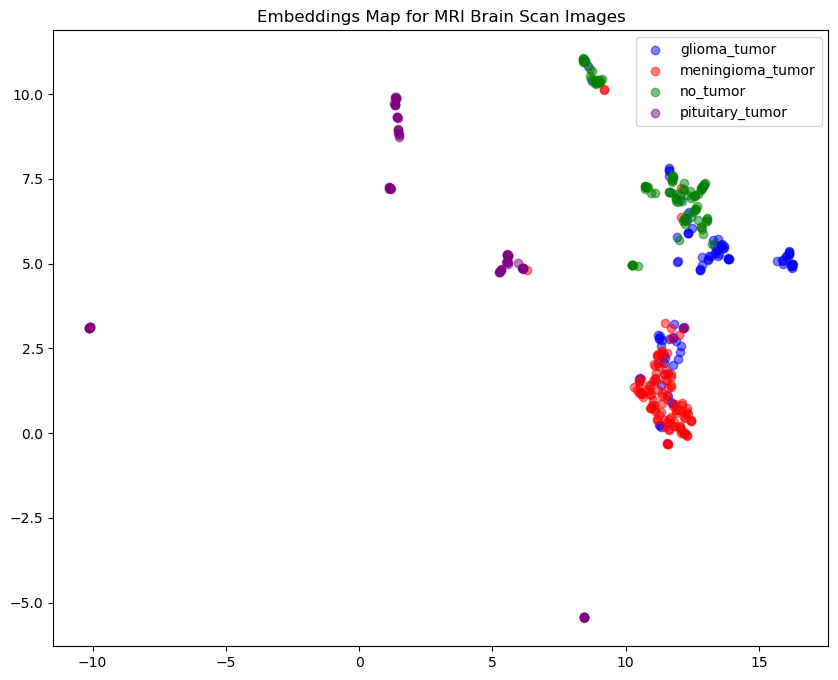

In [28]:
# Create a figure for plotting
plt.figure(figsize=(10, 8))

# Scatter plot with 'u0' and 'u1' columns as x and y, color mapped by class_labels
for tumor_type, color in zip(tumor_types, class_colors):
    indices_to_plot = [i for i, label in enumerate(class_labels) if label == tumor_type]
    subset = umap_df.iloc[indices_to_plot]
    plt.scatter(subset["u0"], subset["u1"], label=tumor_type, color=color, alpha=0.5)

# beutify plot
plt.title("Embeddings Map for MRI Brain Scan Images")
plt.legend()
plt.show()

As shown above, the network is able to separate most of the data between classes, but there is still some overlap, especially with the glioma class (shown in blue). However, for the vast majority of points on the graph, their "nearest neighbors" belong to the same class as them. Therefore, when conducting vector similarity search using the embeddings, the majority of our results should be from the same class.

## 3. Store Embeddings in KDB.AI

### Connect to KDB.AI Session

To use KDB.AI, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI session using `kdbai.Session` and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables `KDBAI_ENDPOINTS` and `KDBAI_API_KEY` exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect.
If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

In [29]:
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)

KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

In [30]:
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Define Vector DB Table Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings. Our table will contain three columns, identical to those in our embeddings DataFrame: 
1. `source`: filepath to the raw image file
2. `class`: tumor class label
3. `embedding`: 2048-dimension feature vectors for similarity search

In [31]:
image_schema = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims": 2048, "metric": "L2", "type": "hnsw"},
        },
    ]
}

### Crate Vector DB Table

We then use the KDB.AI `create_table()` function to create a table that matches the defined schema in the vector database.

In [32]:
# ensure the table does not already exist
try:
    session.table("mri").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [33]:
table = session.create_table("mri", image_schema)

### Add Embedded Data to KDB.AI Table

It is a good idea to check the memory usage of our data before inserting in to KDB.AI.

In [34]:
# convert bytes to MB
embedded_df.memory_usage(deep=True).sum() / (1024**2)

6.236385345458984

This dataset contains only 6MB, so we can insert all the data at once. For bigger image datasets, we should split the data into batches and insert <10MB at a time.

In [35]:
table.insert(embedded_df)

True

### Verify Data Has Been Inserted

Running `table.query()` should show us that data has been added.

In [36]:
table.query()

,source,class,embedding
0,data/glioma_tumor/glioma_tumor_0.png,glioma,"[0.0, 1.3172649145126343, 0.20154666900634766,..."
1,data/glioma_tumor/glioma_tumor_1.png,glioma,"[0.10450763255357742, 0.559810221195221, 0.870..."
2,data/glioma_tumor/glioma_tumor_10.png,glioma,"[0.055571720004081726, 1.653620958328247, 1.16..."
3,data/glioma_tumor/glioma_tumor_11.png,glioma,"[0.7401718497276306, 0.6310665607452393, 0.324..."
4,data/glioma_tumor/glioma_tumor_12.png,glioma,"[0.21819375455379486, 0.19898559153079987, 0.0..."
...,...,...,...
389,data/pituitary_tumor/pituitary_tumor_71.png,pituitary,"[0.1535000056028366, 1.7610539197921753, 1.467..."
390,data/pituitary_tumor/pituitary_tumor_72.png,pituitary,"[0.1535000056028366, 1.7610539197921753, 1.467..."
391,data/pituitary_tumor/pituitary_tumor_73.png,pituitary,"[0.0, 1.1767886877059937, 1.2333405017852783, ..."
392,data/pituitary_tumor/pituitary_tumor_8.png,pituitary,"[0.367981880903244, 0.07278978824615479, 0.017..."


## 4. Query KDB.AI Table

Now that all the embeddings of the images are in KDB.AI's database, it's time to demonstrate KDB.AI's fast query capabilities.

The `query` function accepts a wide range of arguments to make it easy to filter, aggregate, and sort.
Run `?table.query` to see them all.

Let's demonstrate this by filtering for images that contain "glioma" in the filename.

In [37]:
table.query(filter=[("like", "class", "*glioma_tumor*")])

,source,class,embedding
0,data/glioma_tumor/glioma_tumor_0.png,glioma,"[0.0, 1.3172649145126343, 0.20154666900634766,..."
1,data/glioma_tumor/glioma_tumor_1.png,glioma,"[0.10450763255357742, 0.559810221195221, 0.870..."
2,data/glioma_tumor/glioma_tumor_10.png,glioma,"[0.055571720004081726, 1.653620958328247, 1.16..."
3,data/glioma_tumor/glioma_tumor_11.png,glioma,"[0.7401718497276306, 0.6310665607452393, 0.324..."
4,data/glioma_tumor/glioma_tumor_12.png,glioma,"[0.21819375455379486, 0.19898559153079987, 0.0..."
...,...,...,...
95,data/glioma_tumor/glioma_tumor_95.png,glioma,"[0.6331982016563416, 0.5156578421592712, 0.037..."
96,data/glioma_tumor/glioma_tumor_96.png,glioma,"[1.1890076398849487, 0.10027773678302765, 0.25..."
97,data/glioma_tumor/glioma_tumor_97.png,glioma,"[0.528931736946106, 0.37649887800216675, 0.011..."
98,data/glioma_tumor/glioma_tumor_98.png,glioma,"[1.0254501104354858, 0.8127456903457642, 0.083..."


## 5. Search For Similar Images To A Target Image

Finally, let's perform similarity search on the images. We do this using the `table.search()` function.

### Choose Example Image

First let's select a random row from our test dataset and plot the image.

In [38]:
# Get a sample row
random_row_index_1 = 40

In [39]:
# Select the random row and the desired column's value
random_row_1 = embedded_df.iloc[random_row_index_1]

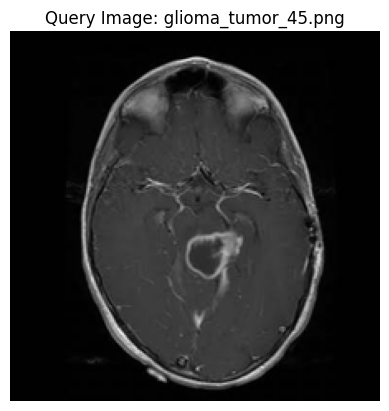

In [40]:
plot_image(plt.subplots()[-1], random_row_1["source"], label="Query Image")

We will save the embedding for this image in the `sample embedding` variable.

In [41]:
sample_embedding_1 = random_row_1["embedding"]

### Search Based On The Chosen Image

Using the the embeddings we extracted above in `sample_embedding` for this random image, we can call `table.search()` to find the `8` nearest neighbors to our query image.

In a real life scenario, the sample images used to search would be ones selected by a doctor.

In [42]:
results_1 = table.search([sample_embedding_1], n=8)
results_1[0]

,source,class,embedding,__nn_distance
0,data/glioma_tumor/glioma_tumor_45.png,glioma,"[0.6581199169158936, 0.7380955219268799, 0.374...",0.000000
1,data/glioma_tumor/glioma_tumor_71.png,glioma,"[0.5400809645652771, 0.6335983872413635, 0.327...",655.003113
2,data/glioma_tumor/glioma_tumor_61.png,glioma,"[1.1261733770370483, 1.0511531829833984, 0.607...",695.868652
3,data/glioma_tumor/glioma_tumor_95.png,glioma,"[0.6331982016563416, 0.5156578421592712, 0.037...",709.470642
4,data/glioma_tumor/glioma_tumor_47.png,glioma,"[0.7627273797988892, 1.3249704837799072, 0.009...",711.554810
5,data/glioma_tumor/glioma_tumor_68.png,glioma,"[0.5686506032943726, 1.2953143119812012, 0.092...",714.166260
6,data/glioma_tumor/glioma_tumor_41.png,glioma,"[0.14557020366191864, 0.7579463124275208, 1.33...",716.417358
7,data/glioma_tumor/glioma_tumor_46.png,glioma,"[1.7890287637710571, 0.47240081429481506, 0.27...",734.459351


The results returned from `table.search()` show the closest matches along with value of nearest neighbor distances `__nn_distance`. Since our query vector is taken from this dataset, the "nearest neighbour" will be the query image itself, with a `__nn_distance` of zero.

### Plot Most Similar Images

Let's visualize these images. The function `plot_test_result_with_8NN()` will plot our query image alongside its 8 nearest neighbours.

In [43]:
def plot_test_result_with_8NN(test_file: str, neighbors: pd.Series) -> None:
    # create figure
    _, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
    axes = ax.reshape(-1)

    # plot query image
    plot_image(axes[0], test_file, "Test")

    # plot nearest neighbors
    for i, (_, value) in enumerate(neighbors.items(), start=1):
        plot_image(axes[i], value, f"{i}-NN")

In [44]:
nn1_filenames = results_1[0]["source"]

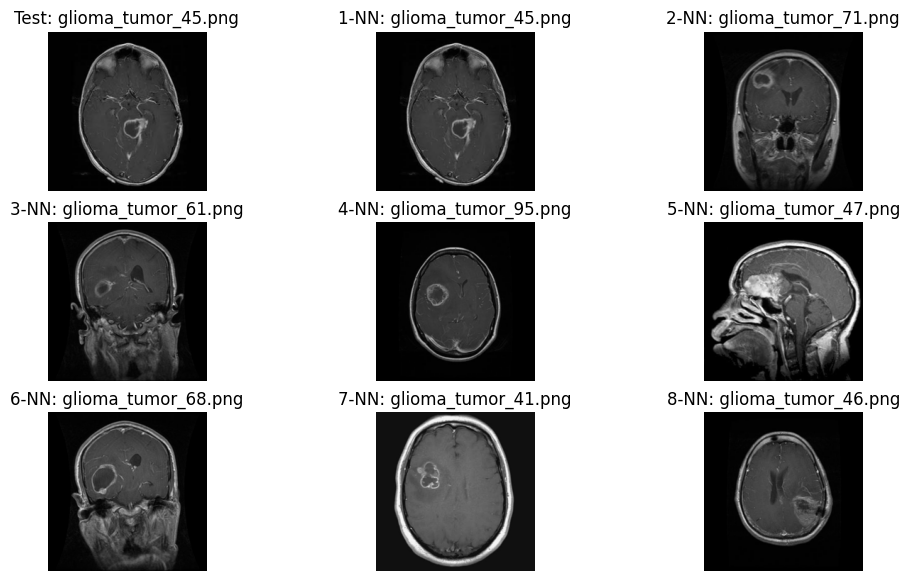

In [45]:
plot_test_result_with_8NN(random_row_1["source"], nn1_filenames)

We can see that the images returned are similar in nature to the test image.

### Automate This Search Process

In [46]:
def mri_image_nn_search(table, df: pd.DataFrame, row_index: int) -> None:
    # Select the random row and the desired column's value
    row = df.iloc[row_index]

    # get the embedding from this row
    row_embedding = row["embedding"]

    # search for 8 nearest neighbors
    nn_results = table.search([row_embedding], n=8)

    # plot the neighbors
    plot_test_result_with_8NN(row["source"], nn_results[0]["source"])

Let's try another sample image and search for similar images.

In [47]:
# Get another row
random_row_index_2 = 210

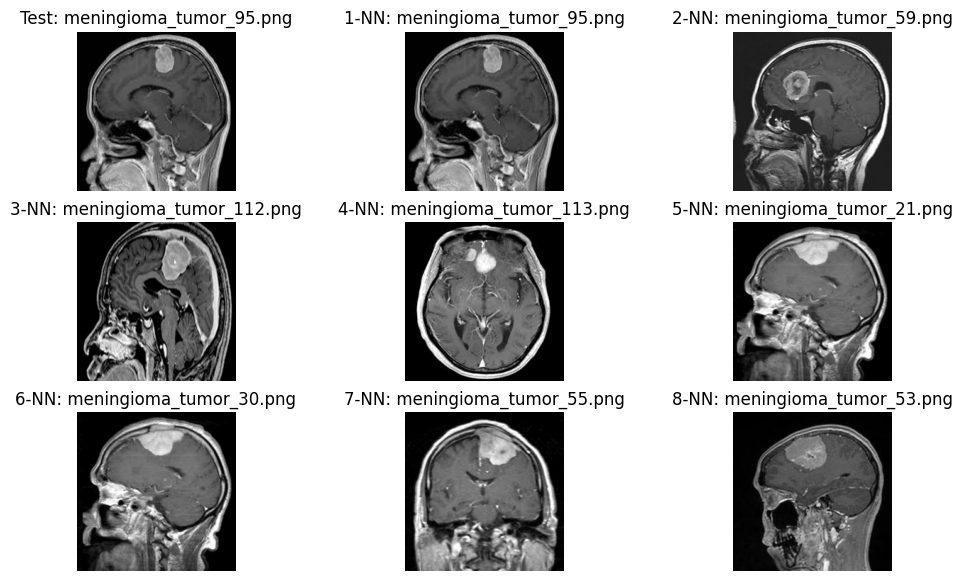

In [48]:
mri_image_nn_search(table, embedded_df, random_row_index_2)

We can see with this second test image that we get a set of similar brain scans back that match the second test image closely and are all in the same category. This kind of result can help a doctor confirm their own assumptions.

## 6. Delete the KDB.AI Table

Once finished with the table, it is best practice to drop it.

In [49]:
table.drop()

True